In [1]:
import numpy as np
import pandas as pd
import geopandas as gp
from sklearn.metrics import r2_score
import statsmodels.api as sm
from scipy.stats import gaussian_kde
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import gridspec
plt.rcParams.update({'font.size': 18})
%matplotlib inline

cm_data = np.loadtxt("/Users/davidlafferty/Projects/misc/ScientificColourMaps5/batlow/batlow.txt")
batlow_map = LinearSegmentedColormap.from_list("Batlow", cm_data)

cm_data = np.loadtxt("/Users/davidlafferty/Projects/misc/ScientificColourMaps5/cork/cork.txt")
cork_map = LinearSegmentedColormap.from_list("Cork", cm_data)

cm_data = np.loadtxt("/Users/davidlafferty/Projects/misc/ScientificColourMaps5/berlin/berlin.txt")
berlin_map = LinearSegmentedColormap.from_list("Berlin", cm_data)

# Import plotting shapefiles
county_shp = gp.read_file('../data/conus_shp/conus_plot/final/counties_contig_plot.shp')
county_shp["GEOID"] = county_shp["GEOID"].astype(str).str.zfill(5)

states = gp.read_file('../data/conus_shp/conus_plot/final/states_contig_plot.shp')
coast = gp.read_file('../data/conus_shp/conus_plot/final/coast_contig_plot.shp')

## Plot 0: Trends in Ag variables

In [7]:
# Yield model results
YieldModelRes = pd.read_csv('../data/GMFD_all/fitting/gmfd_regression_res_60-05.csv')
YieldModelRes['GEOID'] = YieldModelRes['GEOID'].astype(str).str.zfill(5)
YieldModelRes['state'] = YieldModelRes['GEOID'].str[:2]

# Select loosely defined 'Midwest' climate zone
select_states = ['17', '18', '29', '19', '27', '55', '39', '26', '38', '46', '31', '20']
YieldModelResStates = YieldModelRes.copy()
YieldModelResStates.set_index(['state'], inplace = True)
YieldModelResStates = YieldModelResStates.loc[select_states]
YieldModelResStates.reset_index(inplace = True)

select_counties = YieldModelResStates.query('pval < 0.05')['GEOID'].unique()

In [23]:
# Climate Data
nex = pd.read_csv('./combine/output/nex_agvar_hist.csv')
# nex = pd.read_csv('./combine/output/nex_agvar_proj.csv')
nex["GEOID"] = nex["GEOID"].astype(str).str.zfill(5)
nex['state'] = nex['GEOID'].apply(lambda x: x[:2])
nex.set_index(['GEOID'], inplace = True)
# nex = nex.loc[select_counties]
nex = nex.query('Year >= 1960 and Year <= 2005')
nex.reset_index(inplace=True)
nex.set_index(['AgVar', 'GEOID', 'Year'], inplace = True)

# cmip = pd.read_csv('./combine/output/cmip_agvar_all.csv')
# cmip["GEOID"] = cmip["GEOID"].astype(str).str.zfill(5)
# cmip['state'] = cmip['GEOID'].apply(lambda x: x[:2])
# cmip.set_index(['GEOID'], inplace = True)
# cmip = cmip.loc[select_counties]
# cmip = cmip.query('Year >= 2020 and Year <= 2100')
# cmip.reset_index(inplace=True)
# cmip.set_index(['AgVar', 'GEOID', 'Year'], inplace = True)

In [24]:
# Spatial mean
nex_mean = nex.std(level = ['AgVar', 'GEOID'])
# cmip_mean = cmip.mean(level = ['AgVar', 'Year'])

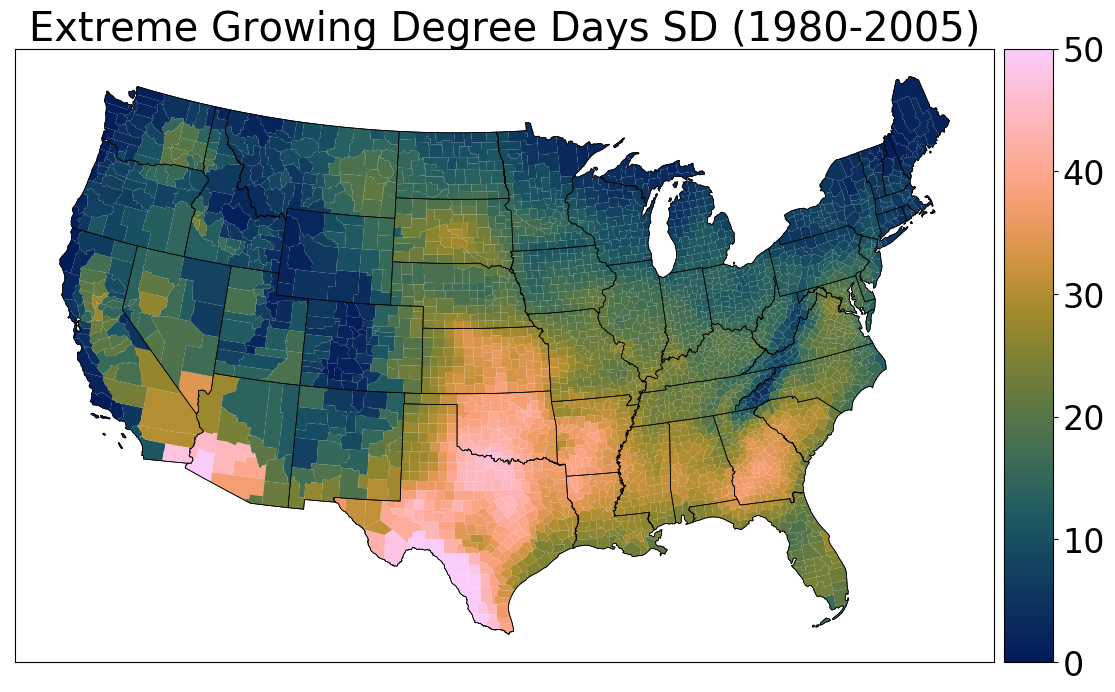

In [31]:
# Plot all R2 values
fig, ax = plt.subplots(1,1, figsize=(12, 12))
mpl.style.use('default')
mpl.style.use('default')
plt.rcParams.update({'font.size': 24})
data = pd.merge(county_shp,nex_mean.loc['egdd'].filter(['GMFD']).reset_index(), on=['GEOID'], how='outer', copy=False)
vmin, vmax = 0., 50.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
data.dropna().plot(column='GMFD', ax = ax, cax = cax, legend=True, vmin = vmin, vmax = vmax, cmap = batlow_map)
states.geometry.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", color=None)
coast.geometry.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", color=None)
ax.tick_params(labelbottom=False, labelleft=False, color = 'white')
ax.set_title('Extreme Growing Degree Days SD (1980-2005)')
# Show
plt.tight_layout()
plt.savefig('./figs/egdd_hist_map.png', dpi = 500)

In [ ]:
# Spatial mean
nex_mean = nex.mean(level = ['AgVar', 'Year'])
cmip_mean = cmip.mean(level = ['AgVar', 'Year'])

In [ ]:
# GDD plot
mpl.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 24, 'xtick.labelsize':24,'ytick.labelsize':24,'axes.labelsize': 24,'axes.titlesize':24})
fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (24,10), sharex=True)

for model in nex_mean.columns[:-3]:
    ax[0].plot(nex_mean.loc['gdd'].index, nex_mean.loc['gdd'][model], color = 'darkgray', label = None, alpha = 0.5)
ax[0].plot(nex_mean.loc['gdd'].index, nex_mean.loc['gdd']['GMFD'], color = 'firebrick', label = 'GMFD')
ax[0].plot(nex_mean.loc['gdd'].index, nex_mean.loc['gdd']['ensemble_mean'], color = 'black', label = 'Ensemble Mean')
ax[0].set_title('NEX models')
ax[0].set_ylabel('GDD')

for model in cmip_mean.columns[:-3]:
    ax[1].plot(cmip_mean.loc['gdd'].index, cmip_mean.loc['gdd'][model], color = 'darkgray', label = None, alpha = 0.5)
ax[1].plot(cmip_mean.loc['gdd'].index, cmip_mean.loc['gdd']['GMFD'], color = 'firebrick', label = 'GMFD')
ax[1].plot(cmip_mean.loc['gdd'].index, cmip_mean.loc['gdd']['ensemble_mean'], color = 'black', label = 'Ensemble Mean')
ax[1].set_title('CMIP models')
ax[1].set_ylabel('GDD')
ax[1].set_xlabel('Year')

ax[0].legend(loc = 'upper left')
plt.savefig('./gdd_hist.png', dpi=500)

In [ ]:
# eGDD plot
mpl.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 24, 'xtick.labelsize':24,'ytick.labelsize':24,'axes.labelsize': 24,'axes.titlesize':24})
fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (24,10), sharex=True)

for model in nex_mean.columns[:-3]:
    ax[0].plot(nex_mean.loc['egdd'].index, nex_mean.loc['egdd'][model], color = 'darkgray', label = None, alpha = 0.5)
ax[0].plot(nex_mean.loc['egdd'].index, nex_mean.loc['egdd']['GMFD'], color = 'firebrick', label = 'GMFD')
ax[0].plot(nex_mean.loc['egdd'].index, nex_mean.loc['egdd']['ensemble_mean'], color = 'black', label = 'Ensemble Mean')
ax[0].set_title('NEX models')
ax[0].set_ylabel('Extreme GDD')

for model in cmip_mean.columns[:-3]:
    ax[1].plot(cmip_mean.loc['egdd'].index, cmip_mean.loc['egdd'][model], color = 'darkgray', label = None, alpha = 0.5)
ax[1].plot(nex_mean.loc['egdd'].index, nex_mean.loc['egdd']['GMFD'], color = 'firebrick', label = 'GMFD')
ax[1].plot(nex_mean.loc['egdd'].index, nex_mean.loc['egdd']['ensemble_mean'], color = 'black', label = 'Ensemble Mean')
ax[1].set_title('CMIP models')
ax[1].set_ylabel('Extreme GDD')
ax[1].set_xlabel('Year')

ax[0].legend()
plt.savefig('./egdd_hist.png', dpi=500)

In [ ]:
# Precip plot
mpl.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 24, 'xtick.labelsize':24,'ytick.labelsize':24,'axes.labelsize': 24,'axes.titlesize':24})
fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (24,10), sharex=True)

for model in nex_mean.columns[:-3]:
    ax[0].plot(nex_mean.loc['prcp'].index, nex_mean.loc['prcp'][model], color = 'darkgray', label = None, alpha = 0.5)
ax[0].plot(nex_mean.loc['prcp'].index, nex_mean.loc['prcp']['GMFD'], color = 'firebrick', label = 'GMFD')
ax[0].plot(nex_mean.loc['prcp'].index, nex_mean.loc['prcp']['ensemble_mean'], color = 'black', label = 'Ensemble Mean')
ax[0].set_title('NEX models')
ax[0].set_ylabel('Precipitation ($m m^{-2}$)')

for model in cmip_mean.columns[:-3]:
    ax[1].plot(cmip_mean.loc['prcp'].index, cmip_mean.loc['prcp'][model], color = 'darkgray', label = None, alpha = 0.5)
ax[1].plot(nex_mean.loc['prcp'].index, nex_mean.loc['prcp']['GMFD'], color = 'firebrick', label = 'GMFD')
ax[1].plot(nex_mean.loc['prcp'].index, nex_mean.loc['prcp']['ensemble_mean'], color = 'black', label = 'Ensemble Mean')
ax[1].set_title('CMIP models')
ax[1].set_ylabel('Precipitation ($m m^{-2}$)')
ax[1].set_xlabel('Year')

ax[0].legend(loc = 'upper left')
plt.savefig('./prcp_hist.png', dpi=500)

In [ ]:
# GDD plot
mpl.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 24, 'xtick.labelsize':24,'ytick.labelsize':24,'axes.labelsize': 24,'axes.titlesize':24})
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (24,10))

ax.plot(cmip_mean.loc['gdd'].index, cmip_mean.loc['gdd'][cmip_mean.columns[0]], color = 'darkgray', label = 'CMIP', alpha = 0.7)
for model in cmip_mean.columns[1:-2]:
    ax.plot(cmip_mean.loc['gdd'].index, cmip_mean.loc['gdd'][model], color = 'darkgray', label = None, alpha = 0.5)

ax.plot(nex_mean.loc['gdd'].index, nex_mean.loc['gdd'][nex_mean.columns[0]], color = 'darkgreen', label = 'NEX', alpha = 0.7)
for model in nex_mean.columns[1:-2]:
    ax.plot(nex_mean.loc['gdd'].index, nex_mean.loc['gdd'][model], color = 'darkgreen', label = None, alpha = 0.5)

ax.set_xlabel('Year')
ax.set_ylabel('Days')
ax.set_ylim([1200,3000])
ax.legend(loc = 'upper left')
ax.set_title('RCP 8.5 Growing Degree Days Projections')
plt.tight_layout()
plt.savefig('./figs/gdd_proj.png', dpi = 500)

In [ ]:
# eGDD plot
mpl.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 24, 'xtick.labelsize':24,'ytick.labelsize':24,'axes.labelsize': 24,'axes.titlesize':24})
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (24,10))

ax.plot(cmip_mean.loc['egdd'].index, cmip_mean.loc['egdd'][cmip_mean.columns[0]], color = 'darkgray', label = 'CMIP', alpha = 0.7)
for model in cmip_mean.columns[1:-2]:
    ax.plot(cmip_mean.loc['egdd'].index, cmip_mean.loc['egdd'][model], color = 'darkgray', label = None, alpha = 0.5)

ax.plot(nex_mean.loc['egdd'].index, nex_mean.loc['egdd'][nex_mean.columns[0]], color = 'darkgreen', label = 'NEX', alpha = 0.7)
for model in nex_mean.columns[1:-2]:
    ax.plot(nex_mean.loc['egdd'].index, nex_mean.loc['egdd'][model], color = 'darkgreen', label = None, alpha = 0.5)

ax.set_xlabel('Year')
ax.set_ylabel('Days')
ax.legend(loc = 'upper left')
ax.set_title('RCP 8.5 Extreme Growing Degree Days Projections')
plt.tight_layout()
plt.savefig('./figs/egdd_proj.png', dpi = 500)

In [ ]:
# Precip plot
mpl.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 24, 'xtick.labelsize':24,'ytick.labelsize':24,'axes.labelsize': 24,'axes.titlesize':24})
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (24,10))

ax.plot(cmip_mean.loc['prcp'].index, cmip_mean.loc['prcp'][cmip_mean.columns[0]], color = 'darkgray', label = 'CMIP', alpha = 0.7)
for model in cmip_mean.columns[1:-2]:
    ax.plot(cmip_mean.loc['prcp'].index, cmip_mean.loc['prcp'][model], color = 'darkgray', label = None, alpha = 0.5)

ax.plot(nex_mean.loc['prcp'].index, nex_mean.loc['prcp'][nex_mean.columns[0]], color = 'darkgreen', label = 'NEX', alpha = 0.7)
for model in nex_mean.columns[1:-2]:
    ax.plot(nex_mean.loc['prcp'].index, nex_mean.loc['prcp'][model], color = 'darkgreen', label = None, alpha = 0.5)

ax.set_xlabel('Year')
ax.set_ylabel('$m m^{-2}$')
ax.legend(loc = 'upper left')
ax.set_title('RCP 8.5 Precipitation Projections')
plt.tight_layout()
plt.savefig('./figs/prcp_proj.png', dpi = 500)

## Plot 1: Yield model regression results

Yield model details: County level quadratic time trends, 1980-2005. Each of 4 coefficients are forced to exhibit the correct sign. Each of 4 predictors is centered before fitting, as are targets (we do not fit an intercept).
The yield model generally does well across the entire U.S. but we can subset based on a goodness-of-fit criterion, here $p < 0.05$

In [ ]:
# Read results
YieldModelRes = pd.read_csv('../data/GMFD_all/fitting/gmfd_regression_res.csv')
YieldModelRes['GEOID'] = YieldModelRes['GEOID'].astype(str).str.zfill(5)
YieldModelRes['state'] = YieldModelRes['GEOID'].str[:2]

In [ ]:
# Plot all R2 values
fig, ax = plt.subplots(1,1, figsize=(12, 12))
mpl.style.use('default')
mpl.style.use('default')
plt.rcParams.update({'font.size': 24})
vmin, vmax = 0.0, 1.0
data = pd.merge(county_shp, YieldModelRes, on=['GEOID'], how='outer', copy=False)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
data.dropna().plot(column='R2', ax = ax, cax = cax, legend=True, vmin = vmin, vmax = vmax, cmap = batlow_map)
states.geometry.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", color=None)
coast.geometry.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", color=None)
ax.tick_params(labelbottom=False, labelleft=False, color = 'white')
ax.set_title('$R^2$ (all counties; 1980-2005)')
# Show
plt.tight_layout()
plt.savefig('./figs/R2_all.png', dpi = 500)

In [ ]:
# Plot p < 0.05
fig, ax = plt.subplots(1,1, figsize=(12, 12))
mpl.style.use('default')
mpl.style.use('default')
plt.rcParams.update({'font.size': 24})
vmin, vmax = 0.0, 1.0
data = pd.merge(county_shp, YieldModelRes.query('pval < 0.05'), on=['GEOID'], how='outer', copy=False)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
data.dropna().plot(column='R2', ax = ax, cax = cax, legend=True, vmin = vmin, vmax = vmax, cmap = batlow_map)
states.geometry.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", color=None)
coast.geometry.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", color=None)
ax.tick_params(labelbottom=False, labelleft=False, color = 'white')
ax.set_title('$R^2$ (counties with F-test $p < 0.05$)')
# Show
plt.tight_layout()
plt.savefig('./figs/R2_pval.png', dpi = 500)

In [ ]:
# Select loosely defined 'Midwest' climate zone
select_states = ['17', '18', '29', '19', '27', '55', '39', '26', '38', '46', '31', '20']
YieldModelResStates = YieldModelRes.copy()
YieldModelResStates.set_index(['state'], inplace = True)
YieldModelResStates = YieldModelResStates.loc[select_states]
YieldModelResStates.reset_index(inplace = True)

In [ ]:
# Plot p < 0.05
fig, ax = plt.subplots(1,1, figsize=(12, 12))
mpl.style.use('default')
mpl.style.use('default')
plt.rcParams.update({'font.size': 24})
vmin, vmax = 0.0, 1.0
data = pd.merge(county_shp, YieldModelResStates.query('pval < 0.05'), on=['GEOID'], how='outer', copy=False)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
data.dropna().plot(column='R2', ax = ax, cax = cax, legend=True, vmin = vmin, vmax = vmax, cmap = batlow_map)
states.geometry.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", color=None)
coast.geometry.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", color=None)
ax.tick_params(labelbottom=False, labelleft=False, color = 'white')
ax.set_title('$R^2$ (Midwestern counties with F-test $p < 0.05$)')
# Show
plt.tight_layout()
plt.savefig('./figs/R2_MW_pval.png', dpi = 500)

In [33]:
# What fraction of US production is accounted for by these counties?
select_counties = YieldModelResStates.query('pval < 0.05')['GEOID'].unique()

weights = pd.read_csv('./national/weights/usda_county_to_national_weights.csv')
weights["GEOID"] = weights["GEOID"].astype(str).str.zfill(5)
weights.sort_values(by = ['GEOID', 'year'], inplace = True)
weights.set_index(['GEOID', 'year'], inplace = True)

print('Number of counties: ' + str(len(select_counties)))
print('Fraction of total US maize: ' + str(weights.loc[select_counties].query('year >= 1980 and year <= 2005').mean(level = 'GEOID').sum()['national_weight']))

Number of counties: 704
Fraction of total US maize: 0.7062484586662364


In [ ]:
#### Aggregated trend
# GMFD
gmfd = pd.read_csv('../data/ACI_output/raw/GMFD/agvar_historical_gmfd.csv')
gmfd = gmfd.query('Year >= 1980 and Year <= 2005')
gmfd.sort_values(by = ['GEOID', 'Year'], inplace = True)
gmfd['GEOID'] = gmfd['GEOID'].astype(str).str.zfill(5)
gmfd['prcp2'] = gmfd['prcp']**2
gmfd.set_index(['GEOID', 'Year'], inplace = True)
# Subtract means
for agvar in gmfd.columns:
    gmfd[agvar] = gmfd[agvar] - gmfd[agvar].mean(level = 'GEOID')

# Calculate Yields
gmfd = pd.merge(YieldModelRes.reset_index(), gmfd.reset_index(), on = ['GEOID'], how = 'outer')
gmfd.set_index(['GEOID', 'Year'], inplace = True)
gmfd['GMFD'] = gmfd['gdd']*gmfd['GDDc'] + gmfd['egdd']*gmfd['KDDc'] + gmfd['prcp']*gmfd['Pc'] + gmfd['prcp2']*gmfd['P2c']
gmfd = gmfd.filter(['GEOID', 'Year', 'GMFD'])

# USDA
usda = pd.read_csv('../data/USDA/final/USDA_county_yields_w_county_quad_trends.csv')
usda = usda.query("year >= 1980 and year <= 2005")
usda["GEOID"] = usda["state_fips_code"].astype(str).str.zfill(2) + usda["county_code"].astype(str).str.zfill(3)
usda.sort_values(by = ['GEOID', 'year'], inplace = True)
usda.set_index(['GEOID', 'year'], inplace = True)
# Subtract means
usda['target_ValueQ'] = usda['target_ValueQ'] - usda['target_ValueQ'].mean(level = 'GEOID')

# Merge for weighted
gmfd_weighted = pd.merge(gmfd.reset_index(), usda.reset_index().filter(['GEOID', 'year', 'target_ValueQ', 'quad_fit', 'log_Value']), left_on = ['GEOID', 'Year'], right_on = ['GEOID', 'year'])
gmfd_weighted = pd.merge(gmfd_weighted, weights.reset_index().filter(['GEOID', 'year', 'national_weight']), left_on = ['GEOID', 'Year'], right_on = ['GEOID', 'year']).drop(columns = ['year_x', 'year_y'])
gmfd_weighted.set_index(['GEOID', 'Year'], inplace = True)
gmfd_weighted = gmfd_weighted.loc[select_counties]

# Sum (EQUALLY WEIGHTED COUNTIES)
gmfd_weighted.rename(columns = {'GMFD_x' : 'GMFD'}, inplace=True)
# gmfd_weighted['national_weight'] = gmfd_weighted['national_weight'] / gmfd_weighted['national_weight'].sum(level = 'Year')
# gmfd_weighted['GMFD'] = gmfd_weighted['GMFD'] * gmfd_weighted['national_weight']
# gmfd_weighted['target_ValueQ'] = gmfd_weighted['target_ValueQ'] * gmfd_weighted['national_weight']
# gmfd_weighted['quad_fit'] = gmfd_weighted['quad_fit'] * gmfd_weighted['national_weight']
# gmfd_weighted['log_Value'] = gmfd_weighted['log_Value'] * gmfd_weighted['national_weight']
gmfd_weighted = gmfd_weighted.groupby('Year').mean()

In [ ]:
# Plot
mpl.style.use('fivethirtyeight')
fig, ax = plt.subplots(1,1, figsize = (16,8))
plt.rcParams.update({'font.size': 24, 'xtick.labelsize':24,'ytick.labelsize':24,'axes.labelsize': 24,'axes.titlesize':24})
gmfd_weighted['log_Value'].plot(ax = ax, label = 'USDA', color = 'C1')
gmfd_weighted['quad_fit'].plot(ax = ax, color = 'gray', alpha = 0.6, label = 'Quadratic Fit')
ax.plot(gmfd_weighted.index, gmfd_weighted['quad_fit'] + gmfd_weighted['GMFD'], label = 'Quadratic Fit + Yield Model')
ax.set_ylabel('Log(Yield)')
ax.set_title('Midwestern counties with F-test $p<0.05$ (equally weighted)')
ax.xaxis.label.set_size(24)
ax.yaxis.label.set_size(24)
plt.legend()
plt.tight_layout()
plt.savefig('./figs/trend_1.png', dpi=500)

In [ ]:
# R-squared
n = len(gmfd_weighted)
p1 = 2
r2 = r2_score(gmfd_weighted['log_Value'], gmfd_weighted['quad_fit'])
print('R-squared: ' + str(r2))
print('Adj. R-squared: ' + str(1. - (1. - r2)*((n-1)/(n-p1-1))))

In [ ]:
# R-squared
n = len(gmfd_weighted)
p2 = 6
r2 = r2_score(gmfd_weighted['log_Value'], gmfd_weighted['quad_fit'] + gmfd_weighted['GMFD'])
print('R-squared: ' + str(r2))
print('Adj. R-squared: ' + str(1. - (1. - r2)*((n-1)/(n-p2-1))))

In [ ]:
# F-test
import scipy.stats as ss
SSEbase = np.sum(gmfd_weighted['target_ValueQ']**2)
SSEfull = np.sum((gmfd_weighted['GMFD'] - gmfd_weighted['target_ValueQ'])**2)
F = ((SSEbase - SSEfull)/(p2-p1))/(SSEfull/(n-p2-1))

In [ ]:
print('F-statistic:')
print(F)
print('p-value:')
print(ss.f.sf(F, p2-p1, n-p2-1))

## Plot 2: Climate models do not capture year-to-year deviations!

In [ ]:
# Climate Data
nex = pd.read_csv('./combine/output/nex_yield_80-05.csv')
nex["GEOID"] = nex["GEOID"].astype(str).str.zfill(5)
# nex['state'] = nex['GEOID'].apply(lambda x: x[:2])
nex.set_index(['GEOID', 'Year'], inplace = True)
nex = nex.loc[select_counties]

cmip = pd.read_csv('./combine/output/cmip_yield_80-05.csv')
cmip["GEOID"] = cmip["GEOID"].astype(str).str.zfill(5)
# cmip['state'] = cmip['GEOID'].apply(lambda x: x[:2])
cmip.set_index(['GEOID', 'Year'], inplace = True)
cmip = cmip.loc[select_counties]

In [ ]:
# Plot
mpl.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 24, 'xtick.labelsize':24,'ytick.labelsize':24,'axes.labelsize': 24,'axes.titlesize':24})
nex_mean = nex.mean(level = 'Year')
cmip_mean = cmip.mean(level = 'Year')

fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (15,10), sharex=True)
for model in nex_mean.columns[:-3]:
    ax[0].plot(gmfd_weighted.index, gmfd_weighted['quad_fit'] + nex_mean[model],color = 'gray', label = None, alpha = 0.5)
ax[0].plot(gmfd_weighted.index, gmfd_weighted['quad_fit'] + nex_mean['ensemble_mean'], label = 'Ensemble Mean', color = 'black')
ax[0].plot(gmfd_weighted.index, gmfd_weighted['quad_fit'] + nex_mean['GMFD'], label = 'GMFD')
ax[0].plot(gmfd_weighted.index, gmfd_weighted['quad_fit'] + nex_mean['USDA'], label = 'USDA', color = 'C1')
ax[0].set_ylim([4.0,5.3])
ax[0].set_title('NEX models')
ax[0].set_ylabel('Log(Yield)')
ax[0].xaxis.label.set_size(24)
ax[0].yaxis.label.set_size(24)
ax[0].legend(loc = 'lower right')

for model in cmip_mean.columns[:-3]:
    ax[1].plot(gmfd_weighted.index, gmfd_weighted['quad_fit'] + cmip_mean[model],color = 'gray', label = None, alpha = 0.5)
ax[1].plot(gmfd_weighted.index, gmfd_weighted['quad_fit'] + cmip_mean['ensemble_mean'], label = 'Ensemble Mean', color = 'black')
ax[1].plot(gmfd_weighted.index, gmfd_weighted['quad_fit'] + cmip_mean['GMFD'], label = 'GMFD')
ax[1].plot(gmfd_weighted.index, gmfd_weighted['quad_fit'] + cmip_mean['USDA'], label = 'USDA', color = 'C1')
ax[1].set_ylim([3.5,5.8])
ax[1].set_title('CMIP models')
ax[1].set_ylabel('Log(Yield)')
ax[1].set_xlabel('Year')
ax[1].xaxis.label.set_size(24)
ax[1].yaxis.label.set_size(24)
plt.tight_layout()
plt.savefig('./figs/trend_2.png', dpi=500)

In [ ]:
# Get R2 values
nex_r2 = []
cmip_r2 = []
for model in nex_mean.columns[:-2]:
    nex_r2.append(r2_score(nex_mean['USDA'], nex_mean[model]))
    cmip_r2.append(r2_score(cmip_mean['USDA'], cmip_mean[model]))

In [ ]:
# Plot
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (12,6))
ax.bar(range(22), height = cmip_r2, color = 'black', alpha = 0.7)
ax.bar(range(22), height = nex_r2, color = 'gray', alpha = 0.7)
ax.set_xlabel('Model')
ax.set_ylabel('$R^2$')
plt.show()

## Plot 3: Instead we need to collapse the time dimension and look at the distribution 

In [ ]:
# Plot
mpl.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 24})
models = nex.columns[:-3]
fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (20,15), sharex=True)
nex['GMFD'].plot(kind = 'density', xlim = [-0.5, 0.5], ax = ax[0], legend = 'GMFD', color = 'firebrick', zorder = 5)
# nex['USDA'].plot(kind = 'density', xlim = [-0.5, 0.5], ax = ax[0], color = 'C1', legend = 'USDA')
kde = gaussian_kde(nex.filter(models).to_numpy().flatten(), bw_method=nex.filter(models).to_numpy().flatten().std(ddof=1))
ax[0].plot(np.linspace(-0.5,0.5,1000), kde.evaluate(np.linspace(-0.5,0.5,1000)), color = 'darkblue', label = 'Mean')
ax[0].legend()
for model in nex.columns[:-3]:
    nex[model].plot(kind = 'density', xlim = [-0.5, 0.5], color = 'darkgray', legend = None, ax = ax[0], alpha = 0.5, linewidth = 2)
ax[0].set_ylim([0.,7.])
ax[0].set_title('NEX models')
ax[0].set_xlabel('Log(Yield Anomaly)')

for model in cmip.columns[:-3]:
    cmip[model].plot(kind = 'density', xlim = [-0.5, 0.5], color = 'darkgray', legend = None, ax = ax[1], alpha = 0.5, linewidth = 2)
cmip['GMFD'].plot(kind = 'density', xlim = [-0.5, 0.5], ax = ax[1], color = 'firebrick', zorder = 5)
# cmip['USDA'].plot(kind = 'density', xlim = [-0.5, 0.5], ax = ax[1], color = 'C1')
kde = gaussian_kde(cmip.filter(models).to_numpy().flatten(), bw_method=cmip.filter(models).to_numpy().flatten().std(ddof=1))
ax[1].plot(np.linspace(-0.5,0.5,1000), kde.evaluate(np.linspace(-0.5,0.5,1000)), color = 'darkblue', label = 'Mean KDE')
ax[1].set_ylim([0.,7.])
ax[1].set_title('CMIP models')
ax[1].set_xlabel('Log(Yield Anomaly)')
plt.tight_layout()
plt.savefig('./figs/kde_1.png', dpi=500)

In [ ]:
# QQ plots
mpl.style.use('fivethirtyeight')
fontsize = 16
models = nex.columns[:-3]
plt.rcParams.update({'font.size': fontsize, 'xtick.labelsize' : fontsize, 'ytick.labelsize' : fontsize, 'axes.labelsize' : fontsize, 'axes.titlesize' : fontsize})
fig, axs = plt.subplots(nrows = 5, ncols = 4, figsize = (45,38))
for ax, model in zip(axs.flat, models.drop(['MRI-CGCM3'])):
    min_bound = np.abs(np.min([nex['GMFD'], nex[model], cmip['GMFD'], cmip[model]]))
    max_bound = np.abs(np.max([nex['GMFD'], nex[model], cmip['GMFD'], cmip[model]]))
    ax.plot([-1.1*min_bound, 1.1*max_bound], [-1.1*min_bound, 1.1*max_bound], color = 'firebrick', zorder = 5, linewidth = 2)
    ax.plot([100,101], [200,201], color = 'darkgray', label = 'NEX')
    ax.plot([100,101], [200,201], color = 'dimgray', label = 'CMIP')
    ax.scatter(np.sort(nex['GMFD']), np.sort(nex[model]), color = 'darkgray')
    ax.scatter(np.sort(cmip['GMFD']), np.sort(cmip[model]), color = 'dimgray')
    ax.set_xlim([-1.1*min_bound, 1.1*max_bound])
    ax.set_ylim([-1.1*min_bound, 1.1*max_bound])
    ax.set_xlabel('GMFD')
    ax.set_ylabel(model)
    if model == nex.columns[0]:
        ax.legend()
plt.tight_layout()
plt.show()

In [ ]:
# QQ plots
mpl.style.use('fivethirtyeight')
fontsize = 24
models = nex.columns[:-3]
plt.rcParams.update({'font.size': fontsize, 'xtick.labelsize' : fontsize, 'ytick.labelsize' : fontsize, 'axes.labelsize' : fontsize, 'axes.titlesize' : fontsize})
fig, axs = plt.subplots(nrows = 5, ncols = 4, figsize = (50,40))
for ax, model in zip(axs.flat, models.drop(['MRI-CGCM3'])):
    min_bound = np.abs(np.min([nex['GMFD'], nex[model]]))
    max_bound = np.abs(np.max([nex['GMFD'], nex[model]]))
    ax.plot([-1.1*min_bound, 1.1*max_bound], [-1.1*min_bound, 1.1*max_bound], color = 'firebrick', zorder = 5, linewidth = 2)
    ax.plot([100,101], [200,201], color = 'darkgray', label = 'NEX')
    ax.plot([100,101], [200,201], color = 'dimgray', label = 'CMIP')
    ax.scatter(np.sort(nex['GMFD']), np.sort(nex[model]), color = 'darkgray')
    ax.scatter(np.sort(cmip['GMFD']), np.sort(cmip[model]), color = 'dimgray')
    ax.set_xlim([-1.1*min_bound, 1.1*max_bound])
    ax.set_ylim([-1.1*min_bound, 1.1*max_bound])
#     ax.set_xlabel('GMFD')
    ax.set_ylabel(model)
    if model == nex.columns[0]:
        ax.legend()
plt.tight_layout()
plt.savefig('./figs/QQ_all.png', dpi=500)

In [ ]:
mpl.style.use('fivethirtyeight')
fig, axs = plt.subplots(nrows = 7, ncols = 3, figsize = (15,30), constrained_layout=True)
models = nex.columns[:-4]
for ax, model in zip(axs.flat, models):
    min_bound = np.abs(np.nanmin([nex['USDA'], nex[model], cmip['USDA'], cmip[model]]))
    max_bound = np.abs(np.nanmax([nex['USDA'], nex[model], cmip['USDA'], cmip[model]]))
    ax.plot([-1.1*min_bound, 1.1*max_bound], [-1.1*min_bound, 1.1*max_bound], color = 'firebrick', zorder = 5)
    ax.plot([100,101], [200,201], color = 'gray', label = 'NEX')
    ax.plot([100,101], [200,201], color = 'black', label = 'CMIP')
    ax.scatter(np.sort(nex['USDA']), np.sort(nex[model]), color = 'darkgray')
    ax.scatter(np.sort(cmip['USDA']), np.sort(cmip[model]), color = 'dimgray')
    ax.set_xlim([-1.1*min_bound, 1.1*max_bound])
    ax.set_ylim([-1.1*min_bound, 1.1*max_bound])
    ax.set_xlabel('USDA')
    ax.set_ylabel(model)
    ax.legend()
plt.show()

## Plot 4: Ag variables

In [ ]:
# Climate Data
nex = pd.read_csv('./combine/output/nex_agvar_hist.csv')
nex["GEOID"] = nex["GEOID"].astype(str).str.zfill(5)
nex['state'] = nex['GEOID'].apply(lambda x: x[:2])
nex.set_index(['GEOID'], inplace = True)
nex = nex.loc[select_counties]
nex = nex.query('Year >= 1980 and Year <= 2005')
nex.reset_index(inplace=True)
nex.set_index(['AgVar', 'GEOID', 'Year'], inplace = True)

cmip = pd.read_csv('./combine/output/cmip_agvar_all.csv')
cmip["GEOID"] = cmip["GEOID"].astype(str).str.zfill(5)
cmip['state'] = cmip['GEOID'].apply(lambda x: x[:2])
cmip.set_index(['GEOID'], inplace = True)
cmip = cmip.loc[select_counties]
cmip = cmip.query('Year >= 1980 and Year <= 2005')
cmip.reset_index(inplace=True)
cmip.set_index(['AgVar', 'GEOID', 'Year'], inplace = True)

In [ ]:
# Subtract means
nex = nex - nex.mean(level = ['AgVar', 'GEOID'])
cmip = cmip - cmip.mean(level = ['AgVar', 'GEOID'])

In [ ]:
# Plot KDD
mpl.style.use('fivethirtyeight')
fontsize = 24
plt.rcParams.update({'font.size': fontsize, 'xtick.labelsize' : fontsize, 'ytick.labelsize' : fontsize, 'axes.labelsize' : fontsize, 'axes.titlesize' : fontsize})
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (24,7))
nex.loc['egdd']['GMFD'].plot(kind = 'density', xlim = [-100, 100], ax = ax[0], legend = 'GMFD', color = 'firebrick', zorder = 5)
# kde = gaussian_kde(nex.loc['egdd'].filter(models).to_numpy().flatten(), bw_method=nex.loc['egdd'].filter(models).to_numpy().flatten().std(ddof=1))
# ax[0].plot(np.linspace(-100,100,1000), kde.evaluate(np.linspace(-100,100,1000)), color = 'darkblue', label = 'Mean KDE')
ax[0].legend()
for model in nex.columns[:-3]:
    nex.loc['egdd'][model].plot(kind = 'density', xlim = [-100, 100], color = 'darkgray', legend = None, ax = ax[0], alpha = 0.5, linewidth = 2, bw_method = 0.5)
ax[0].set_title('NEX models')
ax[0].set_xlabel('Extreme GDD Anomaly')

for model in cmip.columns[:-3]:
    cmip.loc['egdd'][model].plot(kind = 'density', xlim = [-100, 100], color = 'darkgray', legend = None, ax = ax[1], alpha = 0.5, linewidth = 2, bw_method = 0.5)
cmip.loc['egdd']['GMFD'].plot(kind = 'density', xlim = [-100, 100], ax = ax[1], color = 'firebrick', zorder = 5)
# kde = gaussian_kde(cmip.loc['egdd'].filter(models).to_numpy().flatten(), bw_method=cmip.loc['egdd'].filter(models).to_numpy().flatten().std(ddof=1))
# ax[1].plot(np.linspace(-100,100,1000), kde.evaluate(np.linspace(-100,100,1000)), color = 'darkblue', label = 'Mean KDE')
ax[1].set_title('CMIP models')
ax[1].set_xlabel('Extreme GDD Anomaly')
plt.tight_layout()
plt.savefig('./figs/gdd_density.png', dpi=500)

In [ ]:
# KDD QQ plots
mpl.style.use('fivethirtyeight')
fontsize = 16
plt.rcParams.update({'font.size': fontsize, 'xtick.labelsize' : fontsize, 'ytick.labelsize' : fontsize, 'axes.labelsize' : fontsize, 'axes.titlesize' : fontsize})
fig, axs = plt.subplots(nrows = 7, ncols = 3, figsize = (15,30), constrained_layout=True)
models = nex.columns.drop(['ensemble_mean', 'state', 'GMFD'])
agvar = 'egdd'
for ax, model in zip(axs.flat, models):
    min_bound = np.abs(np.min([nex.loc['egdd']['GMFD'], nex.loc['egdd'][model]]))
    max_bound = np.abs(np.max([nex.loc['egdd']['GMFD'], nex.loc['egdd'][model]]))
    ax.plot([-1.1*min_bound, 1.1*max_bound], [-1.1*min_bound, 1.1*max_bound], color = 'firebrick', zorder = 5, linewidth = 2)
    ax.plot([100,101], [200,201], color = 'darkgray', label = 'NEX')
    ax.plot([100,101], [200,201], color = 'dimgray', label = 'CMIP')
    ax.scatter(np.sort(nex.loc['egdd']['GMFD']), np.sort(nex.loc['egdd'][model]), color = 'darkgray')
    ax.scatter(np.sort(cmip.loc['egdd']['GMFD']), np.sort(cmip.loc['egdd'][model]), color = 'dimgray')
    ax.set_xlim([-1.1*min_bound, 1.1*max_bound])
    ax.set_ylim([-1.1*min_bound, 1.1*max_bound])
    ax.set_xlabel('GMFD')
    ax.set_ylabel(model)
    if model == nex.columns[0]:
        ax.legend()
plt.tight_layout()
plt.savefig('./figs/egdd_density.png', dpi=500)

In [ ]:
# Plot GDD
mpl.style.use('fivethirtyeight')
fontsize = 24
plt.rcParams.update({'font.size': fontsize, 'xtick.labelsize' : fontsize, 'ytick.labelsize' : fontsize, 'axes.labelsize' : fontsize, 'axes.titlesize' : fontsize})
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (24,7))
nex.loc['gdd']['GMFD'].plot(kind = 'density', ax = ax[0], legend = 'GMFD', color = 'firebrick', zorder = 5)
ax[0].legend()
for model in nex.columns[:-3]:
    nex.loc['gdd'][model].plot(kind = 'density', color = 'darkgray', legend = None, ax = ax[0], alpha = 0.5, linewidth = 2, bw_method = 0.5)
ax[0].set_title('NEX models')
ax[0].set_xlabel('GDD Anomaly')

for model in cmip.columns[:-3]:
    cmip.loc['gdd'][model].plot(kind = 'density', color = 'darkgray', legend = None, ax = ax[1], alpha = 0.5, linewidth = 2, bw_method = 0.5)
cmip.loc['gdd']['GMFD'].plot(kind = 'density', ax = ax[1], color = 'firebrick', zorder = 5)
ax[1].set_title('CMIP models')
ax[1].set_xlabel('GDD Anomaly')

plt.tight_layout()
plt.savefig('./figs/gdd_density.png', dpi=500)

In [ ]:
# GDD QQ plots
mpl.style.use('fivethirtyeight')
fontsize = 16
plt.rcParams.update({'font.size': fontsize, 'xtick.labelsize' : fontsize, 'ytick.labelsize' : fontsize, 'axes.labelsize' : fontsize, 'axes.titlesize' : fontsize})
fig, axs = plt.subplots(nrows = 7, ncols = 3, figsize = (15,30), constrained_layout=True)
agvar = 'gdd'
for ax, model in zip(axs.flat, models):
    min_bound = np.abs(np.min([nex.loc[agvar]['GMFD'], nex.loc[agvar][model]]))
    max_bound = np.abs(np.max([nex.loc[agvar]['GMFD'], nex.loc[agvar][model]]))
    ax.plot([-1.1*min_bound, 1.1*max_bound], [-1.1*min_bound, 1.1*max_bound], color = 'firebrick', zorder = 5, linewidth = 2)
    ax.plot([100,101], [200,201], color = 'darkgray', label = 'NEX')
    ax.plot([100,101], [200,201], color = 'dimgray', label = 'CMIP')
    ax.scatter(np.sort(nex.loc[agvar]['GMFD']), np.sort(nex.loc[agvar][model]), color = 'darkgray')
    ax.scatter(np.sort(cmip.loc[agvar]['GMFD']), np.sort(cmip.loc[agvar][model]), color = 'dimgray')
    ax.set_xlim([-1.1*min_bound, 1.1*max_bound])
    ax.set_ylim([-1.1*min_bound, 1.1*max_bound])
    ax.set_xlabel('GMFD')
    ax.set_ylabel(model)
    if model == nex.columns[0]:
        ax.legend()
plt.show()

In [ ]:
# Plot Precip
mpl.style.use('fivethirtyeight')
fontsize = 24
plt.rcParams.update({'font.size': fontsize, 'xtick.labelsize' : fontsize, 'ytick.labelsize' : fontsize, 'axes.labelsize' : fontsize, 'axes.titlesize' : fontsize})
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (24,7))
nex.loc['prcp']['GMFD'].plot(kind = 'density', ax = ax[0], legend = 'GMFD', color = 'firebrick', zorder = 5)
ax[0].legend()
for model in nex.columns[:-3]:
    nex.loc['prcp'][model].plot(kind = 'density', color = 'darkgray', legend = None, ax = ax[0], alpha = 0.5, linewidth = 2, bw_method = 0.5)
ax[0].set_title('NEX models')
ax[0].set_xlabel('Precip Anomaly')

for model in cmip.columns[:-3]:
    cmip.loc['prcp'][model].plot(kind = 'density', color = 'darkgray', legend = None, ax = ax[1], alpha = 0.5, linewidth = 2, bw_method = 0.5)
cmip.loc['prcp']['GMFD'].plot(kind = 'density', ax = ax[1], color = 'firebrick', zorder = 5)
ax[1].set_title('CMIP models')
ax[1].set_xlabel('Precip Anomaly')
plt.tight_layoutt_layout()
plt.savefig('./figs/prcp_density.png', dpi=500)

In [ ]:
# GDD QQ plots
mpl.style.use('fivethirtyeight')
fontsize = 16
plt.rcParams.update({'font.size': fontsize, 'xtick.labelsize' : fontsize, 'ytick.labelsize' : fontsize, 'axes.labelsize' : fontsize, 'axes.titlesize' : fontsize})
fig, axs = plt.subplots(nrows = 7, ncols = 3, figsize = (15,30), constrained_layout=True)
agvar = 'prcp'
for ax, model in zip(axs.flat, models):
    min_bound = np.abs(np.min([nex.loc[agvar]['GMFD'], nex.loc[agvar][model]]))
    max_bound = np.abs(np.max([nex.loc[agvar]['GMFD'], nex.loc[agvar][model]]))
    ax.plot([-1.1*min_bound, 1.1*max_bound], [-1.1*min_bound, 1.1*max_bound], color = 'firebrick', zorder = 5, linewidth = 2)
    ax.plot([100,101], [200,201], color = 'darkgray', label = 'NEX')
    ax.plot([100,101], [200,201], color = 'dimgray', label = 'CMIP')
    ax.scatter(np.sort(nex.loc[agvar]['GMFD']), np.sort(nex.loc[agvar][model]), color = 'darkgray')
    ax.scatter(np.sort(cmip.loc[agvar]['GMFD']), np.sort(cmip.loc[agvar][model]), color = 'dimgray')
    ax.set_xlim([-1.1*min_bound, 1.1*max_bound])
    ax.set_ylim([-1.1*min_bound, 1.1*max_bound])
    ax.set_xlabel('GMFD')
    ax.set_ylabel(model)
    if model == nex.columns[0]:
        ax.legend()
plt.show()

## Plot 5: 'Out-of-sample' forecast verification

In [34]:
print('Fraction of total US maize: ' + str(weights.loc[select_counties].query('year >= 2006 and year <= 2016').mean(level = 'GEOID').sum()['national_weight']))

Fraction of total US maize: 0.6886422005759208


In [35]:
# Climate Data
nex = pd.read_csv('./combine/output/nex_yield_06-16.csv')
nex["GEOID"] = nex["GEOID"].astype(str).str.zfill(5)
# nex['state'] = nex['GEOID'].apply(lambda x: x[:2])
nex.set_index(['GEOID', 'Year'], inplace = True)
nex = nex.loc[select_counties]

cmip = pd.read_csv('./combine/output/cmip_yield_06-16.csv')
cmip["GEOID"] = cmip["GEOID"].astype(str).str.zfill(5)
# cmip['state'] = cmip['GEOID'].apply(lambda x: x[:2])
cmip.set_index(['GEOID', 'Year'], inplace = True)
cmip = cmip.loc[select_counties]

In [36]:
#### Aggregated trend
# GMFD
gmfd = pd.read_csv('../data/ACI_output/raw/GMFD/agvar_historical_gmfd.csv')
gmfd = gmfd.query('Year >= 2006 and Year <= 2016')
gmfd.sort_values(by = ['GEOID', 'Year'], inplace = True)
gmfd['GEOID'] = gmfd['GEOID'].astype(str).str.zfill(5)
gmfd['prcp2'] = gmfd['prcp']**2
gmfd.set_index(['GEOID', 'Year'], inplace = True)
# Subtract means
for agvar in gmfd.columns:
    gmfd[agvar] = gmfd[agvar] - gmfd[agvar].mean(level = 'GEOID')

# Calculate Yields
gmfd = pd.merge(YieldModelRes.reset_index(), gmfd.reset_index(), on = ['GEOID'], how = 'outer')
gmfd.set_index(['GEOID', 'Year'], inplace = True)
gmfd['GMFD'] = gmfd['gdd']*gmfd['GDDc'] + gmfd['egdd']*gmfd['KDDc'] + gmfd['prcp']*gmfd['Pc'] + gmfd['prcp2']*gmfd['P2c']
gmfd = gmfd.filter(['GEOID', 'Year', 'GMFD'])

# USDA
usda = pd.read_csv('../data/USDA/final/USDA_county_yields_w_county_quad_trends.csv')
usda = usda.query("year >= 2006 and year <= 2016")
usda["GEOID"] = usda["state_fips_code"].astype(str).str.zfill(2) + usda["county_code"].astype(str).str.zfill(3)
usda.sort_values(by = ['GEOID', 'year'], inplace = True)
usda.set_index(['GEOID', 'year'], inplace = True)
# Subtract means
usda['target_ValueQ'] = usda['target_ValueQ'] - usda['target_ValueQ'].mean(level = 'GEOID')

# Merge for weighted
gmfd_weighted = pd.merge(gmfd.reset_index(), usda.reset_index().filter(['GEOID', 'year', 'target_ValueQ', 'quad_fit', 'log_Value']), left_on = ['GEOID', 'Year'], right_on = ['GEOID', 'year'])
gmfd_weighted = pd.merge(gmfd_weighted, weights.reset_index().filter(['GEOID', 'year', 'national_weight']), left_on = ['GEOID', 'Year'], right_on = ['GEOID', 'year']).drop(columns = ['year_x', 'year_y'])
gmfd_weighted.set_index(['GEOID', 'Year'], inplace = True)
gmfd_weighted = gmfd_weighted.loc[select_counties]

# Sum (EQUALLY WEIGHTED COUNTIES)
gmfd_weighted.rename(columns = {'GMFD_x' : 'GMFD'}, inplace=True)
# gmfd_weighted['national_weight'] = gmfd_weighted['national_weight'] / gmfd_weighted['national_weight'].sum(level = 'Year')
# gmfd_weighted['GMFD'] = gmfd_weighted['GMFD'] * gmfd_weighted['national_weight']
# gmfd_weighted['target_ValueQ'] = gmfd_weighted['target_ValueQ'] * gmfd_weighted['national_weight']
# gmfd_weighted['quad_fit'] = gmfd_weighted['quad_fit'] * gmfd_weighted['national_weight']
# gmfd_weighted['log_Value'] = gmfd_weighted['log_Value'] * gmfd_weighted['national_weight']
gmfd_weighted = gmfd_weighted.groupby('Year').mean()

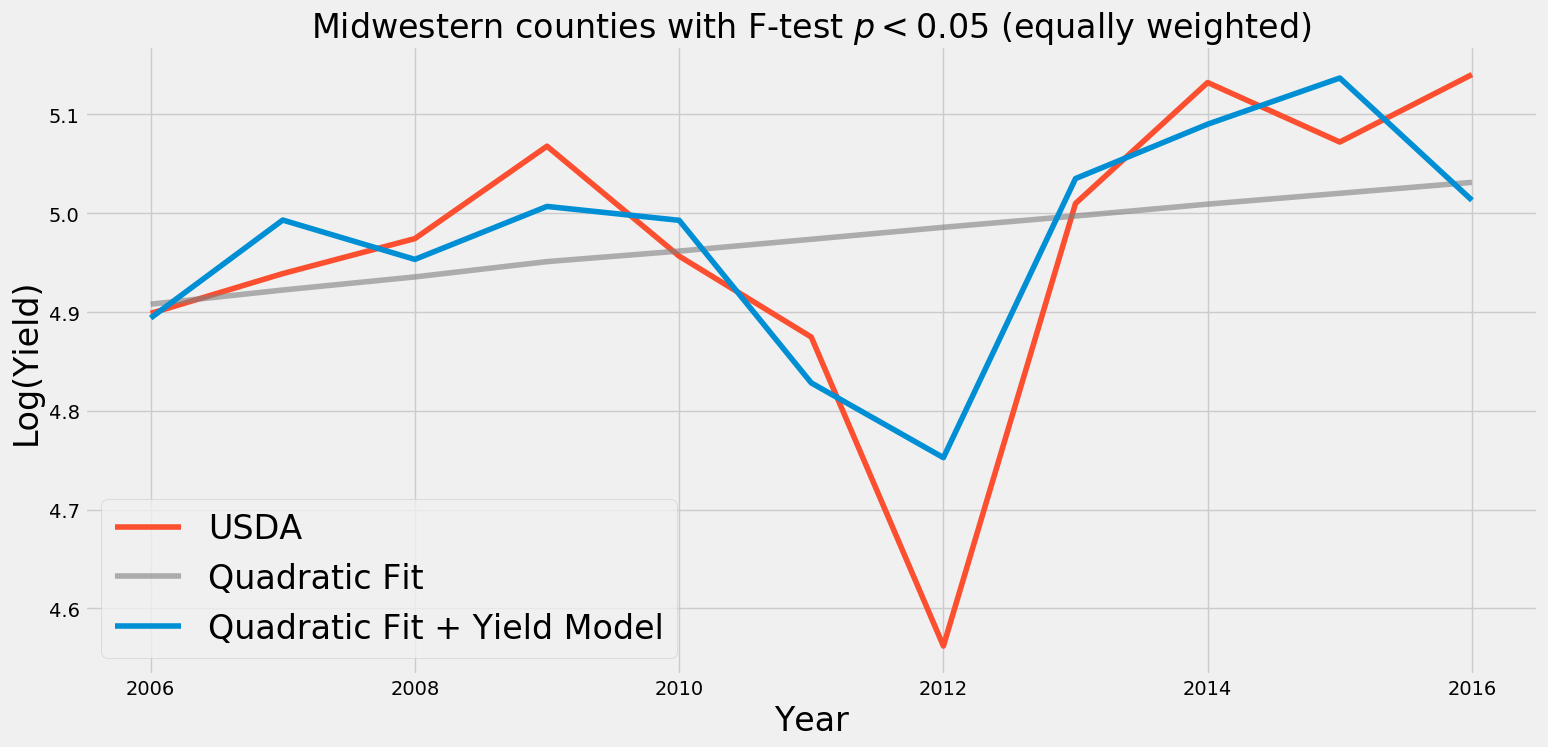

In [37]:
# Plot
mpl.style.use('fivethirtyeight')
fig, ax = plt.subplots(1,1, figsize = (16,8))
plt.rcParams.update({'font.size': 24, 'xtick.labelsize':24,'ytick.labelsize':24,'axes.labelsize': 24,'axes.titlesize':24})
gmfd_weighted['log_Value'].plot(ax = ax, label = 'USDA', color = 'C1')
gmfd_weighted['quad_fit'].plot(ax = ax, color = 'gray', alpha = 0.6, label = 'Quadratic Fit')
ax.plot(gmfd_weighted.index, gmfd_weighted['quad_fit'] + gmfd_weighted['GMFD'], label = 'Quadratic Fit + Yield Model')
ax.set_ylabel('Log(Yield)')
ax.set_title('Midwestern counties with F-test $p<0.05$ (equally weighted)')
ax.xaxis.label.set_size(24)
ax.yaxis.label.set_size(24)
plt.legend()
plt.tight_layout()
plt.savefig('./figs/oos_1.png', dpi=500)

In [38]:
# R-squared
n = len(gmfd_weighted)
p2 = 6
r2 = r2_score(gmfd_weighted['log_Value'], gmfd_weighted['quad_fit'] + gmfd_weighted['GMFD'])
print('R-squared: ' + str(r2))
print('Adj. R-squared: ' + str(1. - (1. - r2)*((n-1)/(n-p2-1))))

R-squared: 0.7304077114992051
Adj. R-squared: 0.32601927874801284


In [ ]:
# Plot
mpl.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 24, 'xtick.labelsize':24,'ytick.labelsize':24,'axes.labelsize': 24,'axes.titlesize':24})
nex_mean = nex.mean(level = 'Year')
cmip_mean = cmip.mean(level = 'Year')

fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (12,10))
for model in nex_mean.columns[:-3]:
    ax[0].plot(gmfd_weighted.index, gmfd_weighted['quad_fit'] + nex_mean[model],color = 'gray', label = None, alpha = 0.5)
ax[0].plot(gmfd_weighted.index, gmfd_weighted['quad_fit'] + nex_mean['ensemble_mean'], label = 'Ensemble Mean', color = 'black')
ax[0].plot(gmfd_weighted.index, gmfd_weighted['quad_fit'] + nex_mean['GMFD'], label = 'GMFD')
ax[0].plot(gmfd_weighted.index, gmfd_weighted['quad_fit'] + nex_mean['USDA'], label = 'USDA', color = 'C1')
ax[0].set_ylim([4.0,5.3])
ax[0].set_title('NEX models')
ax[0].set_ylabel('Log(Yield)')
ax[0].set_xlabel('Year')
ax[0].xaxis.label.set_size(24)
ax[0].yaxis.label.set_size(24)
ax[0].legend()

for model in cmip_mean.columns[:-3]:
    ax[1].plot(gmfd_weighted.index, gmfd_weighted['quad_fit'] + cmip_mean[model],color = 'gray', label = None, alpha = 0.5)
ax[1].plot(gmfd_weighted.index, gmfd_weighted['quad_fit'] + cmip_mean['ensemble_mean'], label = 'Ensemble Mean', color = 'black')
ax[1].plot(gmfd_weighted.index, gmfd_weighted['quad_fit'] + cmip_mean['GMFD'], label = 'GMFD')
ax[1].plot(gmfd_weighted.index, gmfd_weighted['quad_fit'] + cmip_mean['USDA'], label = 'USDA', color = 'C1')
ax[1].set_ylim([3.5,5.8])
ax[1].set_title('CMIP models')
ax[1].set_ylabel('Log(Yield)')
ax[1].set_xlabel('Year')
ax[1].xaxis.label.set_size(24)
ax[1].yaxis.label.set_size(24)
plt.tight_layout()
plt.savefig('./figs/oos_2.png', dpi=500)

In [ ]:
# Plot
mpl.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 24})
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (24,7))
models = nex.columns[:-3]
nex['GMFD'].plot(kind = 'density', xlim = [-0.5, 0.5], ax = ax[0], legend = 'GMFD', color = 'firebrick', zorder = 5)
nex['USDA'].plot(kind = 'density', xlim = [-0.5, 0.5], ax = ax[0], color = 'black', legend = 'USDA')
nex_kde = gaussian_kde(nex.filter(models).to_numpy().flatten(), bw_method=nex.filter(models).to_numpy().flatten().std(ddof=1))
ax[0].plot(np.linspace(-0.5,0.5,1000), nex_kde.evaluate(np.linspace(-0.5,0.5,1000)), color = 'darkblue', label = 'Mean')
ax[0].legend()
for model in nex.columns[:-3]:
    nex[model].plot(kind = 'density', xlim = [-0.5, 0.5], color = 'darkgray', legend = None, ax = ax[0], alpha = 0.5, linewidth = 2)
ax[0].set_ylim([0.,7.])
ax[0].set_title('NEX models')
ax[0].set_xlabel('Log(Yield Anomaly)')

for model in cmip.columns[:-3]:
    cmip[model].plot(kind = 'density', xlim = [-0.5, 0.5], color = 'darkgray', legend = None, ax = ax[1], alpha = 0.5, linewidth = 2)
cmip['GMFD'].plot(kind = 'density', xlim = [-0.5, 0.5], ax = ax[1], color = 'firebrick', zorder = 5)
cmip['USDA'].plot(kind = 'density', xlim = [-0.5, 0.5], ax = ax[1], color = 'black', legend = None)
cmip_kde = gaussian_kde(cmip.filter(models).to_numpy().flatten(), bw_method=cmip.filter(models).to_numpy().flatten().std(ddof=1))
ax[1].plot(np.linspace(-0.5,0.5,1000), cmip_kde.evaluate(np.linspace(-0.5,0.5,1000)), color = 'darkblue', label = 'Mean')
ax[1].set_ylim([0.,7.])
ax[1].set_title('CMIP models')
ax[1].set_xlabel('Log(Yield Anomaly)')
plt.tight_layout()
plt.savefig('./figs/oos_3.png', dpi=500)

In [ ]:
# Plot 2012 anomalies
fig, ax = plt.subplots(1,1, figsize=(12, 12))
mpl.style.use('default')
mpl.style.use('default')
plt.rcParams.update({'font.size': 24})

county_shp_plot = county_shp.copy()
county_shp_plot.set_index(['GEOID'], inplace=True)
county_shp_plot = county_shp_plot.loc[select_counties]

gmfd_plot = gmfd.loc[select_counties]

states_plot = states.copy()
states_plot.set_index(['STATEFP'], inplace=True)
states_plot = states_plot.loc[select_states]

vmin, vmax = -0.5,0.5
data = pd.merge(county_shp_plot, gmfd_plot.query('Year == 2012').reset_index(), on=['GEOID'], how='outer', copy=False)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
data.dropna().plot(column='GMFD', ax = ax, cax = cax, legend=True, vmin = vmin, vmax = vmax, cmap = 'RdYlGn')
states_plot.geometry.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", color=None)
# coast.geometry.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", color=None)
ax.tick_params(labelbottom=False, labelleft=False, color = 'white')
ax.set_title('2012 GMFD Log Yield Anomaly')
# Show
plt.tight_layout()
plt.savefig('./figs/oos_4.png', dpi=500)

In [ ]:
# 2012 return periods
gmfd_rp_plot = gmfd_plot.query('Year == 2012')
gmfd_rp_plot['nex_return'] = gmfd_rp_plot['GMFD'].apply(lambda x: 1/(nex_kde.integrate_box_1d(-100., x)))
gmfd_rp_plot['cmip_return'] = gmfd_rp_plot['GMFD'].apply(lambda x: 1/(cmip_kde.integrate_box_1d(-100., x)))

In [ ]:
# Plot 2012 anomalies
fig, ax = plt.subplots(1,2, figsize=(15, 12))
mpl.style.use('default')
mpl.style.use('default')
plt.rcParams.update({'font.size': 24})

vmin, vmax = 0.,50.
data = pd.merge(county_shp_plot, gmfd_rp_plot.reset_index(), on=['GEOID'], how='outer', copy=False)
divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right", size="5%", pad=0.1)
data.dropna().plot(column='nex_return', ax = ax[0], cax = cax, legend=True, vmin = vmin, vmax = vmax, cmap = batlow_map)
states_plot.geometry.boundary.plot(ax=ax[0], linewidth=0.5, edgecolor="black", color=None)
ax[0].tick_params(labelbottom=False, labelleft=False, color = 'white')
ax[0].set_title('NEX')

divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right", size="5%", pad=0.1)
data.dropna().plot(column='cmip_return', ax = ax[1], cax = cax, legend=True, vmin = vmin, vmax = vmax, cmap = batlow_map)
states_plot.geometry.boundary.plot(ax=ax[1], linewidth=0.5, edgecolor="black", color=None)
ax[1].tick_params(labelbottom=False, labelleft=False, color = 'white')
ax[1].set_title('CMIP')

# Show
fig.suptitle('2012 Log Yield Anomaly Estimated Return Period (Years)', y = 0.77)
plt.tight_layout()
plt.savefig('./figs/oos_5.png', dpi=500)

In [ ]:
# QQ plots
mpl.style.use('fivethirtyeight')
fontsize = 16
plt.rcParams.update({'font.size': fontsize, 'xtick.labelsize' : fontsize, 'ytick.labelsize' : fontsize, 'axes.labelsize' : fontsize, 'axes.titlesize' : fontsize})
fig, axs = plt.subplots(nrows = 7, ncols = 3, figsize = (15,30), constrained_layout=True)
models = nex.columns[:-3]
for ax, model in zip(axs.flat, models):
    min_bound = np.abs(np.min([nex['GMFD'], nex[model]]))
    max_bound = np.abs(np.max([nex['GMFD'], nex[model]]))
    ax.plot([-1.1*min_bound, 1.1*max_bound], [-1.1*min_bound, 1.1*max_bound], color = 'firebrick', zorder = 5, linewidth = 2)
    ax.plot([100,101], [200,201], color = 'darkgray', label = 'NEX')
    ax.plot([100,101], [200,201], color = 'dimgray', label = 'CMIP')
    ax.scatter(np.sort(nex['GMFD']), np.sort(nex[model]), color = 'darkgray')
    ax.scatter(np.sort(cmip['GMFD']), np.sort(cmip[model]), color = 'dimgray')
    ax.set_xlim([-1.1*min_bound, 1.1*max_bound])
    ax.set_ylim([-1.1*min_bound, 1.1*max_bound])
#     ax.set_xlim([-2., 1.])
#     ax.set_ylim([-2., 1.])
    ax.set_xlabel('GMFD')
    ax.set_ylabel(model)
    if model == nex.columns[0]:
        ax.legend()
plt.show()

## Plot 6: Projections

In [ ]:
# Climate Data
nex = pd.read_csv('./combine/output/nex_yield_50-80.csv')
nex["GEOID"] = nex["GEOID"].astype(str).str.zfill(5)
# nex['state'] = nex['GEOID'].apply(lambda x: x[:2])
nex.set_index(['GEOID', 'Year'], inplace = True)
nex = nex.loc[select_counties]

cmip = pd.read_csv('./combine/output/cmip_yield_50-80.csv')
cmip["GEOID"] = cmip["GEOID"].astype(str).str.zfill(5)
# cmip['state'] = cmip['GEOID'].apply(lambda x: x[:2])
cmip.set_index(['GEOID', 'Year'], inplace = True)
cmip = cmip.loc[select_counties]

In [ ]:
# GMFD data
gmfd = pd.read_csv('./combine/output/nex_yield_80-05.csv')
gmfd["GEOID"] = gmfd["GEOID"].astype(str).str.zfill(5)
gmfd.set_index(['GEOID', 'Year'], inplace = True)
gmfd = gmfd.loc[select_counties]

In [ ]:
# Plot
mpl.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 24})
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (24,7))
gmfd['GMFD'].plot(kind = 'density', xlim = [-0.5, 0.5], ax = ax[0], color = 'firebrick', zorder = 5, label = 'GMFD (1980-2005)')
ax[0].legend()
for model in nex.columns[:-3]:
    nex[model].plot(kind = 'density', xlim = [-0.5, 0.5], color = 'darkgray', legend = None, ax = ax[0], alpha = 0.5, linewidth = 2)
ax[0].set_ylim([0.,4.])
ax[0].set_title('NEX models (2050-2080)')
ax[0].set_xlabel('Log(Yield Anomaly)')

for model in cmip.columns[:-3].drop(['MRI-CGCM3']):
    cmip[model].plot(kind = 'density', xlim = [-0.5, 0.5], color = 'darkgray', legend = None, ax = ax[1], alpha = 0.5, linewidth = 2)
gmfd['GMFD'].plot(kind = 'density', xlim = [-0.5, 0.5], ax = ax[1], color = 'firebrick', zorder = 5, legend = None)
ax[1].set_ylim([0.,4.])
ax[1].set_title('CMIP models (2050-2080)')
ax[1].set_xlabel('Log(Yield Anomaly)')

plt.tight_layout()
plt.savefig('./figs/yield_proj.png', dpi=500)